In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from bs4 import BeautifulSoup

import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import pickle

In [7]:
## Preparing Data

In [8]:
# Loading Data

df = pd.read_csv(r"C:\Users\Arung\OneDrive\Desktop\PROJECT\CAPSTONE PROJECT 2\SPAM text message 20170820 - Data.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Category    0
Message     0
dtype: int64


<Axes: xlabel='Category', ylabel='count'>

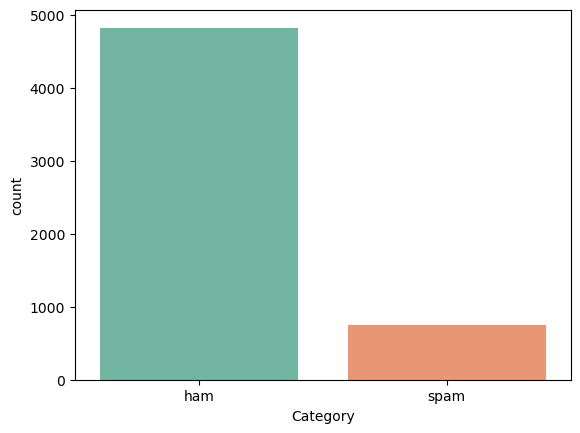

In [10]:
sns.countplot(x="Category", data=df, palette="Set2")

In [11]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arung\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Ensure required NLTK resources are downloaded


def clean_and_preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming 
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens into a single text string
    cleaned_text = " ".join(tokens)
    
    return cleaned_text

In [13]:
df["Message"]=df["Message"].apply(clean_and_preprocess_text)

In [14]:
# Load spaCy language model
nlp = spacy.load('en_core_web_sm')

def lemm(data):
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        doc = nlp(data['Message'].iloc[i])
        for token in doc:
            lemmed.append(token.lemma_)
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['text'] = data['lemmanized'].apply(' '.join)
    data = data.drop("lemmanized", axis=1)
    data = data.drop("Message", axis=1)
    return data

# Call the lemm function with your data
df = lemm(df)

In [15]:
df

,Category,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah do not think goe usf live around though
...,...,...
5567,spam,2nd time tri 2 contact u u £ 750 pound prize 2...
5568,ham,ü b go esplanad fr home
5569,ham,piti mood soani suggest
5570,ham,guy bitch act like i d interest buy someth el ...


In [16]:
mesg = {"ham":0,"spam":1}
df["Category"]=df["Category"].map(mesg)

In [17]:
 #Count the number of occurrences of each class in the "Category" column
count_class_0, count_class_1 = df["Category"].value_counts()

# Split data into two dataframes according to class
df_class_0 = df[df["Category"] == 0]
df_class_1 = df[df["Category"] == 1]

# Subsample the majority class (df_class_1) to equal the number of samples from the minority class.
df_class_1 = df_class_1.sample(count_class_0, replace=True)

# Concatenate the two dataframes to create a new balanced dataframe
balanced_data = pd.concat([df_class_0, df_class_1])

# Extract labels and text data
balanced_labels = balanced_data["Category"]
balanced_text_data = balanced_data["text"]

# Display label count to check balancing
balanced_labels.value_counts()

Category
0    4825
1    4825
Name: count, dtype: int64

In [18]:
# Divide balanced data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_text_data, balanced_labels, test_size=0.2, random_state=42)

## III-Feature Extraction Using TF-IDF Vectorization:

In [20]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the training data using TF-IDF
X_train_transformed = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same TF-IDF configuration
X_test_transformed = tfidf_vectorizer.transform(X_test)

In [21]:
X_test_transformed

<1930x7151 sparse matrix of type '<class 'numpy.float64'>'
	with 21436 stored elements in Compressed Sparse Row format>

## Applying Logistic Regression

In [23]:
# Initialize a Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model

LogisticRegression()

In [24]:
# Train the model using the training data
logistic_regression_model.fit(X_train_transformed, y_train)

LogisticRegression()

In [25]:
# Make predictions on the test data
predictions = logistic_regression_model.predict(X_test_transformed)
predictions 

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [26]:
# Print the accuracy score of the predictions
print("Accuracy Score:", accuracy_score(predictions, y_test))

Accuracy Score: 0.9865284974093265


In [27]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, logistic_regression_model.predict_proba(X_test_transformed)[:, 1])
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9982982837805172


In [28]:
# Create a DataFrame for evaluation metrics
evaluation_metrics = {
    "Accuracy": accuracy_score(y_test, predictions ),
    "Precision": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "F1-Score": f1_score(y_test, predictions),
    "ROC-AUC Score": roc_auc_score(y_test, logistic_regression_model.predict_proba(X_test_transformed)[:, 1])
}

metrics_df = pd.DataFrame([evaluation_metrics])
print("\nEvaluation Metrics Table:")

print(metrics_df)


Evaluation Metrics Table:
   Accuracy  Precision   Recall  F1-Score  ROC-AUC Score
0  0.986528   0.984194  0.98836  0.986272       0.998298


In [29]:
# Check Training and Testing Scores
train_score = logistic_regression_model.score(X_train_transformed, y_train)
test_score = logistic_regression_model.score(X_test_transformed , y_test)
print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

Training Accuracy: 0.9900
Testing Accuracy: 0.9865


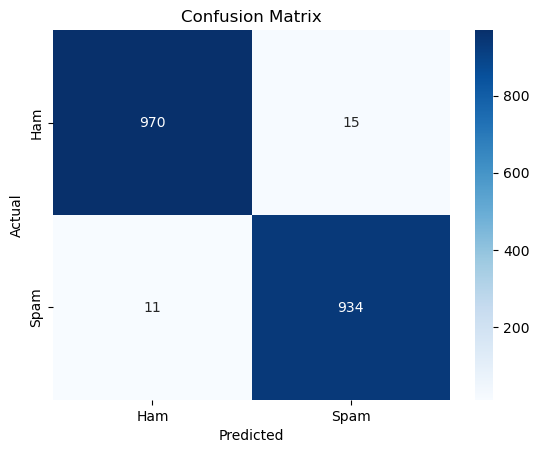

In [30]:
# Analysing Using confusion Matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Applying Random Forest

In [31]:
# Initialize a Random Forest Classifier
random_forest_classifier = RandomForestClassifier()

# Train the classifier using the training data
random_forest_classifier.fit(X_train_transformed, y_train)

# Make predictions on the test data
predictions = random_forest_classifier.predict(X_test_transformed)

# Print the accuracy score of the predictions
print("Accuracy Score:", accuracy_score(predictions, y_test))

Accuracy Score: 0.9989637305699481


In [32]:
# Create a DataFrame for evaluation metrics
evaluation_metrics = {
    "Accuracy": accuracy_score(y_test, predictions ),
    "Precision": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "F1-Score": f1_score(y_test, predictions),
    "ROC-AUC Score": roc_auc_score(y_test, logistic_regression_model.predict_proba(X_test_transformed)[:, 1])
}

metrics_df = pd.DataFrame([evaluation_metrics])
print("\nEvaluation Metrics Table:")

print(metrics_df)


Evaluation Metrics Table:
   Accuracy  Precision    Recall  F1-Score  ROC-AUC Score
0  0.998964        1.0  0.997884  0.998941       0.998298


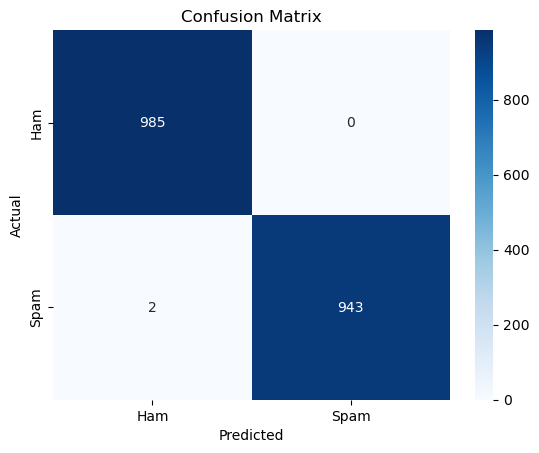

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Implementing SVC

In [35]:
# Initialize a Support Vector Machine classifier
support_vector_machine = SVC()

In [36]:
# Train the classifier using the training data
support_vector_machine.fit(X_train_transformed, y_train)



SVC()

In [37]:
# Make predictions on the test data
predictions = support_vector_machine.predict(X_test_transformed)

# Print the accuracy score of the predictions
print("Accuracy Score:", accuracy_score(predictions, y_test))

Accuracy Score: 0.9984455958549223


In [38]:
# Create a DataFrame for evaluation metrics
evaluation_metrics = {
    "Accuracy": accuracy_score(y_test, predictions ),
    "Precision": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "F1-Score": f1_score(y_test, predictions),
    "ROC-AUC Score": roc_auc_score(y_test, logistic_regression_model.predict_proba(X_test_transformed)[:, 1])
}

metrics_df = pd.DataFrame([evaluation_metrics])
print("\nEvaluation Metrics Table:")

print(metrics_df)


Evaluation Metrics Table:
   Accuracy  Precision    Recall  F1-Score  ROC-AUC Score
0  0.998446   0.998941  0.997884  0.998412       0.998298


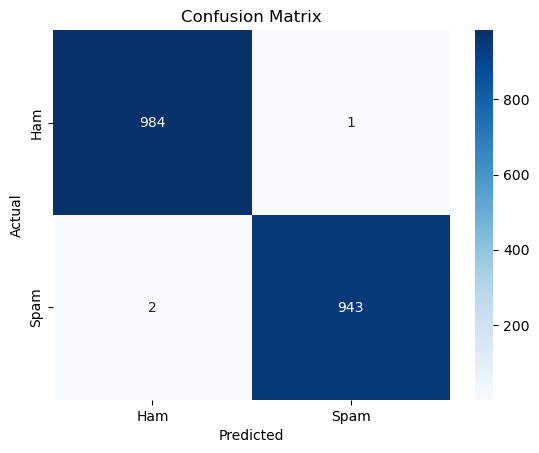

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Testing the Logistic Model with Real SPAM message

In [41]:
import pickle

# Save the trained model
with open("spam_model.pkl", "wb") as model_file:
    pickle.dump(support_vector_machine, model_file)

# Save the TF-IDF vectorizer
with open("vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [42]:
# Load trained model and vectorizer
with open("spam_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

with open("vectorizer.pkl", "rb") as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

# Function to predict spam
def predict_spam(text):
    cleaned_text = clean_and_preprocess_text(text)
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vectorized)
    return "Spam" if prediction[0] == 1 else "Not Spam"

# Test it
print(predict_spam("Congratulations! You've won a prize. Click here to claim!"))  # Expected: Spam

Spam


In [43]:
model_path = "spam_model.pkl"  # Update with actual model path
vectorizer_path = "vectorizer.pkl"  # Update with actual vectorizer path

with open(model_path, 'rb') as model_file:
    model = pickle.load(model_file)
with open(vectorizer_path, 'rb') as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

def predict_spam(text):
    cleaned_text = clean_and_preprocess_text(text)
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vectorized)
    return "Spam" if prediction[0] == 1 else "Not Spam"




# Function to test multiple messages
def test_model(messages):
    results = []
    for msg in messages:
        result = predict_spam(msg)
        results.append((msg, result))
    return results




# Sample messages for testing
test_messages = [
    "Congratulations! You have won a lottery of $1,000,000. Claim now!",
    "Hey, are we still meeting for lunch today?",
    "URGENT! Your account has been compromised. Click this link to secure it.",
    "Don't forget to submit the report by EOD.",
    "FREE entry into our contest! Just reply with WIN to participate."
]

# Run the test and print results
results = test_model(test_messages)
for message, prediction in results:
    print(f"Message: {message}\nPrediction: {prediction}\n")

Message: Congratulations! You have won a lottery of $1,000,000. Claim now!
Prediction: Spam

Message: Hey, are we still meeting for lunch today?
Prediction: Not Spam

Message: URGENT! Your account has been compromised. Click this link to secure it.
Prediction: Not Spam

Message: Don't forget to submit the report by EOD.
Prediction: Not Spam

Message: FREE entry into our contest! Just reply with WIN to participate.
Prediction: Spam



## Conclusion